# Titanic - The Destroyer

In [42]:
# Importing libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the CSV file into a DataFrame
ds = pd.read_csv('Titanic_Dataset.csv')

In [3]:
# Create a connection to the SQLite database
conn = sqlite3.connect('titanic.db')

In [4]:
# Transfer the Dataset to the SQL database
ds.to_sql('titanic_t', conn, if_exists='replace', index=False)

1309

In [5]:
# Close the connection (optional, as we will use it through the magic command)
conn.close()

In [6]:
# Load the ipython-sql extension
%load_ext sql

In [7]:
# Connect to the SQLite database
%sql sqlite:///titanic.db

# Exploratory data analysis (EDA)

In [37]:
# total tables in a db
%sql SELECT name as 'Table Name' FROM sqlite_master WHERE type='table';

 * sqlite:///titanic.db
Done.


Table Name
titanic_t


## Table Info

In [13]:
%sql PRAGMA table_info(titanic_t);

 * sqlite:///titanic.db
Done.


cid,name,type,notnull,dflt_value,pk
0,Passenger_id,INTEGER,0,None,0
1,Age,REAL,0,None,0
2,Fare,REAL,0,None,0
3,Sex,INTEGER,0,None,0
4,sib_sp,INTEGER,0,None,0
5,Par_ch,INTEGER,0,None,0
6,P_class,INTEGER,0,None,0
7,Embarked,REAL,0,None,0
8,Survived,INTEGER,0,None,0


There are no missing values in the dataset.

## In our table, we have 9 columns.

1. Passengers Identity, unique id for every passenger starting from 1 to onwards..
2. Age, Age of the Passengers.
3. Fare, Price they paid for the trip ($).
4. Sex, 0 for Male & 1 For Female.
5. Siblings & Spouses, passengers having siblings and spouses with them.
6. Parent & Children, passengers having parents & there children with them.
7. Passenger class, there are three classes 1st, 2nd and 3rd.
8. Embarked, represents from where passengers boarded the ship, 0.0 for Southampton, 1.0 for Cherbourg, 2.0 for Queenstown.
9. Survived, showing wheather they survived or not, 0 for Did not survive, 1 for Survived.

## Data Structure
Top 5 Rows

In [14]:
%sql select * from titanic_t limit 5

 * sqlite:///titanic.db
Done.


Passenger_id,Age,Fare,Sex,sib_sp,Par_ch,P_class,Embarked,Survived
1,22.0,7.25,0,1,0,3,2.0,0
2,38.0,71.2833,1,1,0,1,0.0,1
3,26.0,7.925,1,0,0,3,2.0,1
4,35.0,53.1,1,1,0,1,2.0,1
5,35.0,8.05,0,0,0,3,2.0,0


## Total Rows

In [15]:
%sql select count(*) as 'Total Rows' from titanic_t;

 * sqlite:///titanic.db
Done.


Total Rows
1309


## Age Categorized, Minor for age Less than 18, Adult for age between 18 - 64 and Senior for age greater than 64 

Creating view for later use

In [16]:
%%sql
DROP VIEW IF EXISTS age_category;

CREATE VIEW age_category AS
SELECT 
    CASE
        WHEN age < 18 THEN 'Minor'
        WHEN age BETWEEN 18 AND 64 THEN 'Adult'
        ELSE 'Senior'
    END AS age_category,
    passenger_id
FROM titanic_t;

 * sqlite:///titanic.db
Done.
Done.


[]

## Pie chart for age category 

In [17]:
%%sql
select age_category, count(*) as 'No. of People' from age_category group by age_category;

 * sqlite:///titanic.db
Done.


age_category,No. of People
Adult,1142
Minor,154
Senior,13


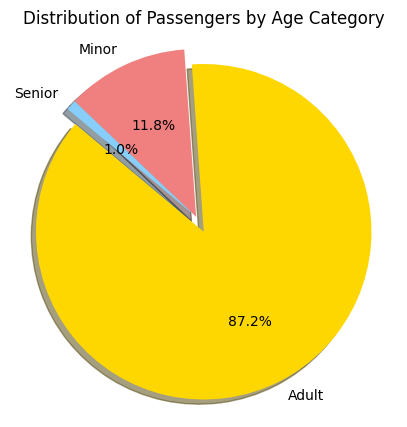

In [18]:
# Data
labels = ['Adult', 'Minor', 'Senior']
sizes = [1142, 154, 13]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # explode the 'Adult' slice

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Passengers by Age Category')
plt.axis('equal')
plt.show()


## Age Distribution by Decade Gap

 * sqlite:///titanic.db
Done.


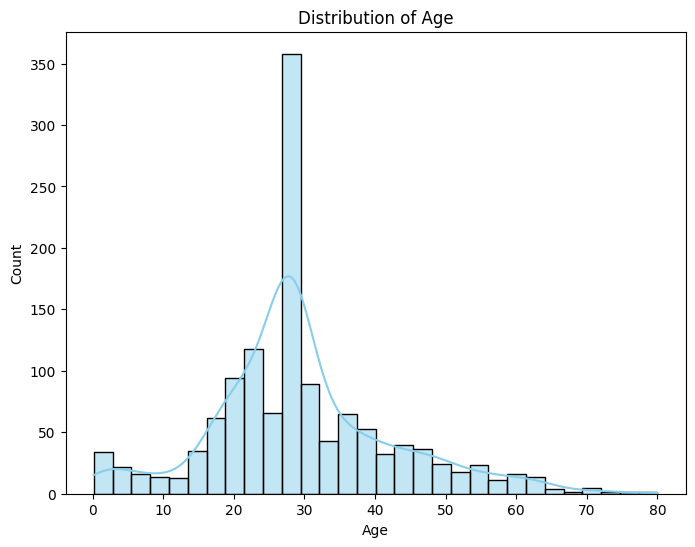

In [19]:
data= %sql select age from titanic_t;

ds = pd.DataFrame(data)
# Histogram of Numerical Variable (Age Distribution)
plt.figure(figsize=(8, 6))
sns.histplot(ds['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

## Survival count by Age Category

In [20]:
%%sql
SELECT ac.age_category, t.Survived, COUNT(*) AS count
FROM age_category ac,  titanic_t t
WHERE ac.passenger_id = t.passenger_id
GROUP BY ac.age_category, t.Survived
ORDER BY ac.age_category, t.Survived;

 * sqlite:///titanic.db
Done.


age_category,Survived,count
Adult,0,862
Adult,1,280
Minor,0,93
Minor,1,61
Senior,0,12
Senior,1,1


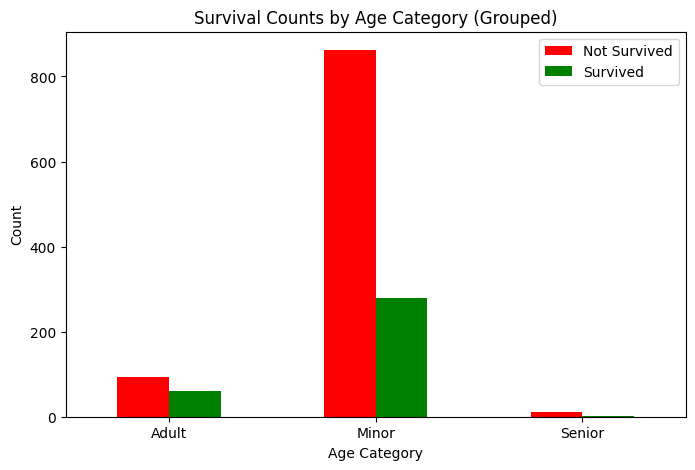

In [21]:
# Sample DataFrame
data = {
    'age_category': ['Minor', 'Minor', 'Adult', 'Adult', 'Senior', 'Senior'],
    'Survived': [0, 1, 0, 1, 0, 1],
    'count': [862, 280, 93, 61, 12, 1]
}

ds = pd.DataFrame(data)

# Pivot the DataFrame for easier plotting
pivot_ds = ds.pivot(index='age_category', columns='Survived', values='count').fillna(0)
pivot_ds.columns = ['Not Survived', 'Survived']

# Plotting Grouped Bar Chart
pivot_ds.plot(kind='bar', figsize=(8, 5), color=['red', 'green'])
plt.title('Survival Counts by Age Category (Grouped)')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'])
plt.xticks(rotation=0)
plt.show()

## Average Fare of Each Class

In [22]:
%%sql
select P_class, Round(AVG(Fare),2) as 'Average Fare $' from titanic_t group by  P_class ;

 * sqlite:///titanic.db
Done.


P_class,Average Fare $
1,87.51
2,21.18
3,13.3


## Distribution by Gender

In [23]:
%%sql 
SELECT 
    CASE
        WHEN Sex = 1 THEN 'Female'
        WHEN Sex = 0 THEN 'Male'
    END AS Gender, 
    COUNT(Sex) AS Count
FROM titanic_t
GROUP BY Gender;

 * sqlite:///titanic.db
Done.


Gender,Count
Female,466
Male,843


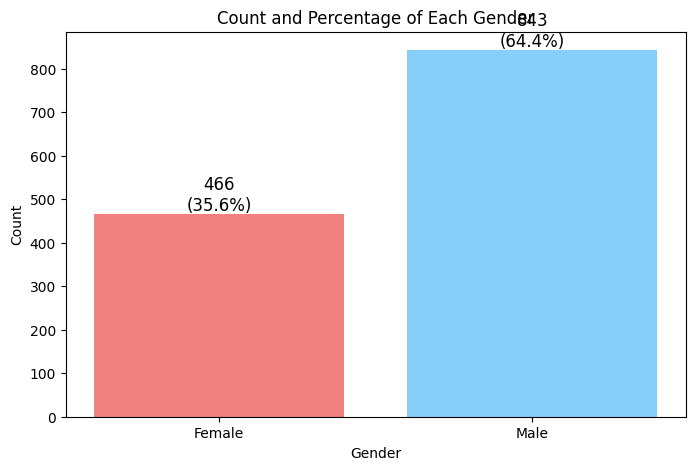

In [44]:
# data
data = {
    'Gender': ['Female', 'Male'],
    'Count': [466, 843]
}

ds = pd.DataFrame(data)

# Calculate percentage
ds['Percentage'] = (ds['Count'] / ds['Count'].sum()) * 100

plt.figure(figsize=(8, 5))

# Create the bar plot
bars = plt.bar(ds['Gender'], ds['Count'], color=['lightcoral', 'lightskyblue'])

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count and Percentage of Each Gender')

for bar, count, percentage in zip(bars, ds['Count'], ds['Percentage']):
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.0, yval, f'{count}\n({percentage:.1f}%)',
        ha='center', va='bottom', fontsize=12
    )
    
plt.show()

## Survival by Passenger class

In [25]:
%%sql
SELECT t.P_class, t.Survived, COUNT(*) AS count
FROM titanic_t t
GROUP BY t.P_class, t.Survived
ORDER BY t.P_class, t.Survived;

 * sqlite:///titanic.db
Done.


P_class,Survived,count
1,0,187
1,1,136
2,0,190
2,1,87
3,0,590
3,1,119


 * sqlite:///titanic.db
Done.


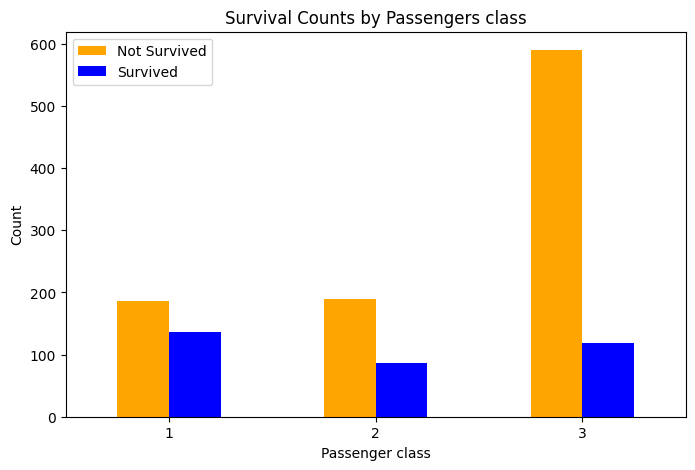

In [40]:
# Sample DataFrame
data = %sql SELECT t.P_class, t.Survived, COUNT(*) AS count FROM titanic_t t GROUP BY t.P_class, t.Survived ORDER BY t.P_class, t.Survived;

ds = pd.DataFrame(data)

# Pivot the DataFrame for easier plotting
pivot_ds = ds.pivot(index='P_class', columns='Survived', values='count').fillna(0)
pivot_ds.columns = ['Not Survived', 'Survived']

# Plotting Grouped Bar Chart
pivot_ds.plot(kind='bar', figsize=(8, 5), color=['orange', 'blue'])
plt.title('Survival Counts by Passengers class')
plt.xlabel('Passenger class')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'])
plt.xticks(rotation=0)
plt.show()

## Total Passengers having Siblings & Spouses with them

In [26]:
%%sql
select P_class, count(sib_sp) as 'Passenger with Siblings & Spouses' from titanic_t where sib_sp >0 group by P_class;

 * sqlite:///titanic.db
Done.


P_class,Passenger with Siblings & Spouses
1,125
2,95
3,198


## Total Passengers having Parents & Children with them

In [27]:
%%sql
select P_class, count(Par_ch) as 'Passenger with Parents & Children' from titanic_t where Par_ch >0 group by P_class;

 * sqlite:///titanic.db
Done.


P_class,Passenger with Parents & Children
1,81
2,71
3,155


## Total Passengers having Siblings & Spouses + Parents & Children

In [28]:
%%sql
select P_class, count(Passenger_id) as 'Passenger with Close Relatives' from titanic_t where sib_sp >0 and Par_ch>0 group by P_class;

 * sqlite:///titanic.db
Done.


P_class,Passenger with Close Relatives
1,43
2,47
3,116


## Total Passengers having Either Siblings & Spouses or Parents & Children

In [29]:
%%sql
select P_class, count(Passenger_id) as 'Passenger with Close Relatives' from titanic_t where sib_sp >0 or Par_ch>0 group by P_class;

 * sqlite:///titanic.db
Done.


P_class,Passenger with Close Relatives
1,163
2,119
3,237


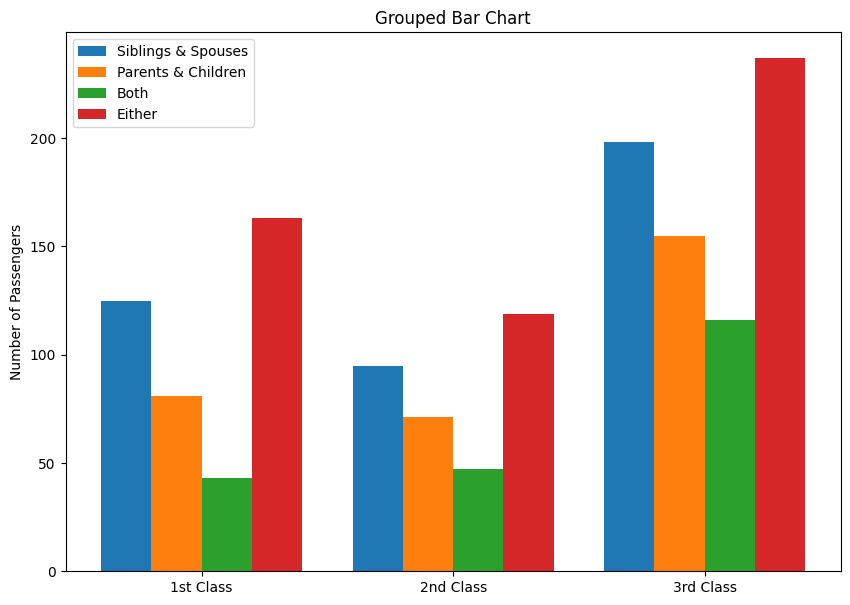

In [46]:
# Data
classes = ['1st Class', '2nd Class', '3rd Class']
siblings_spouses = [125, 95, 198]
parents_children = [81, 71, 155]
both = [43, 47, 116]
either = [163, 119, 237]

# Creating a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Grouped Bar Chart
x = np.arange(len(classes))
width = 0.2

ax.bar(x - width*1.5, siblings_spouses, width, label='Siblings & Spouses')
ax.bar(x - width/2, parents_children, width, label='Parents & Children')
ax.bar(x + width/2, both, width, label='Both')
ax.bar(x + width*1.5, either, width, label='Either')

ax.set_title('Grouped Bar Chart')
ax.set_ylabel('Number of Passengers')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.show()

## Number of People Who Survived, Categorized by the Place They Boarded

In [30]:
%%sql
SELECT Embarked, COUNT(*) as count_survived FROM titanic_t WHERE Survived = 1 and Embarked IS NOT NULL
GROUP BY Embarked;

 * sqlite:///titanic.db
Done.


Embarked,count_survived
0.0,93
1.0,30
2.0,217


## Number of People Who Did Not Survived, Categorized by the Place They Boarded

In [31]:
%%sql
SELECT Embarked, COUNT(*) as count_survived FROM titanic_t WHERE Survived = 0 and Embarked IS NOT NULL
GROUP BY Embarked;

 * sqlite:///titanic.db
Done.


Embarked,count_survived
0.0,177
1.0,93
2.0,697


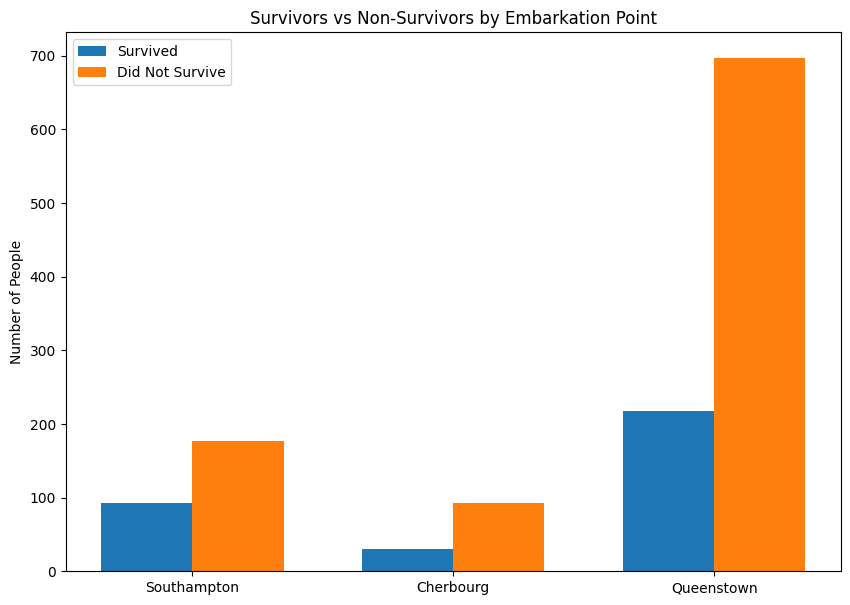

In [48]:
# Data
embarked_labels = ['Southampton', 'Cherbourg', 'Queenstown']
survived_counts = [93, 30, 217]
not_survived_counts = [177, 93, 697]

# Creating a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Grouped Bar Chart
x = np.arange(len(embarked_labels))
width = 0.35

ax.bar(x - width/2, survived_counts, width, label='Survived')
ax.bar(x + width/2, not_survived_counts, width, label='Did Not Survive')

ax.set_title('Survivors vs Non-Survivors by Embarkation Point')
ax.set_ylabel('Number of People')
ax.set_xticks(x)
ax.set_xticklabels(embarked_labels)
ax.legend()

plt.show()

## Correlation Matrix

In [33]:
# Run this for Matrix formation
ds = pd.read_csv('Titanic_Dataset.csv')

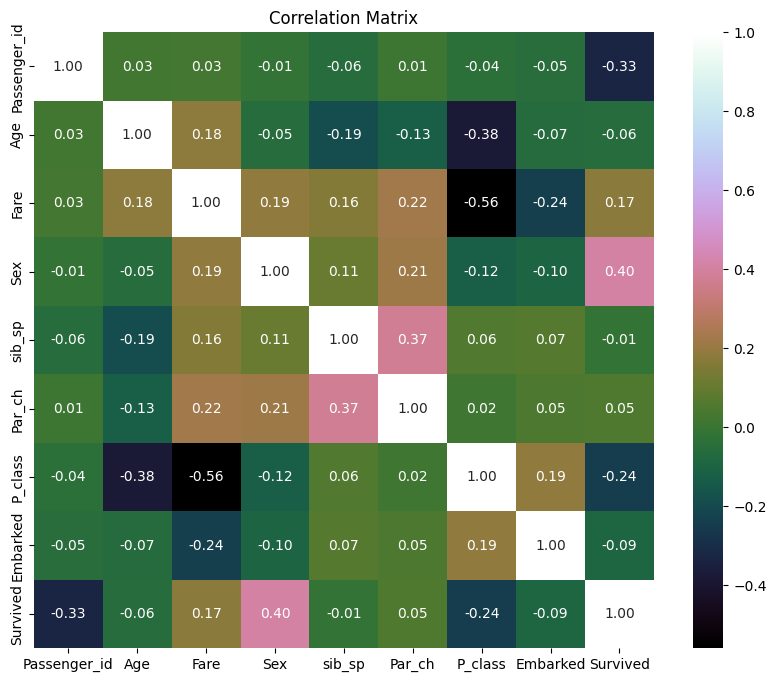

In [34]:
# Heatmap (Correlation Matrix)
plt.figure(figsize=(10, 8))
corr = ds.corr()
sns.heatmap(corr, annot=True, cmap='cubehelix', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Summary

1. **Age Categorization**:
   - Passengers were categorized into three age groups: Minor (age < 18), Adult (18 <= age < 64), and Senior (age >= 64).
   - A pie chart visualized the distribution across these categories, highlighting that most passengers were adults.

2. **Age Distribution by Decade Gap**:
   - The age distribution was analyzed by decades to observe the spread of ages among passengers.

3. **Survival Count by Age Category**:
   - The survival rates were analyzed across the different age categories to identify any patterns in survival based on age.

4. Average Fare of Each Class was calculated.

5. **Distribution by Gender**:
   - The dataset was analyzed to show the gender distribution of the passengers.

6. **Survival by Passenger Class**:
   - Survival rates were analyzed by passenger class to see if class had an impact on survival chances.

7. **Total Passengers Having Siblings & Spouses with Them**:
   - The number of passengers who were traveling with siblings and/or spouses was counted and visualized.

8. **Total Passengers Having Parents & Children with Them**:
   - The number of passengers who were traveling with parents and/or children was counted and visualized.

9. **Total Passengers Having Siblings & Spouses + Parents & Children**:
   - The combined count of passengers traveling with siblings & spouses and parents & children was calculated.

10. **Total Passengers Having Either Siblings & Spouses or Parents & Children**:
    - The count of passengers traveling with either siblings & spouses or parents & children was calculated.

11. **Number of People Who Survived, Categorized by the Place They Boarded**:
    - The survival rates were analyzed based on the embarkation place (Cherbourg, Queenstown, Southampton).

12. **Number of People Who Did Not Survive, Categorized by the Place They Boarded**:
    - The non-survival rates were similarly analyzed based on the embarkation place.

13. **Correlation Matrix**:
    - A correlation matrix was created to identify relationships between different variables in the dataset.

This comprehensive analysis provides a detailed look at various aspects of the Titanic dataset, from demographic distributions and fare details to survival analysis and family travel patterns.

### open to suggestions for any improvements. Thank you

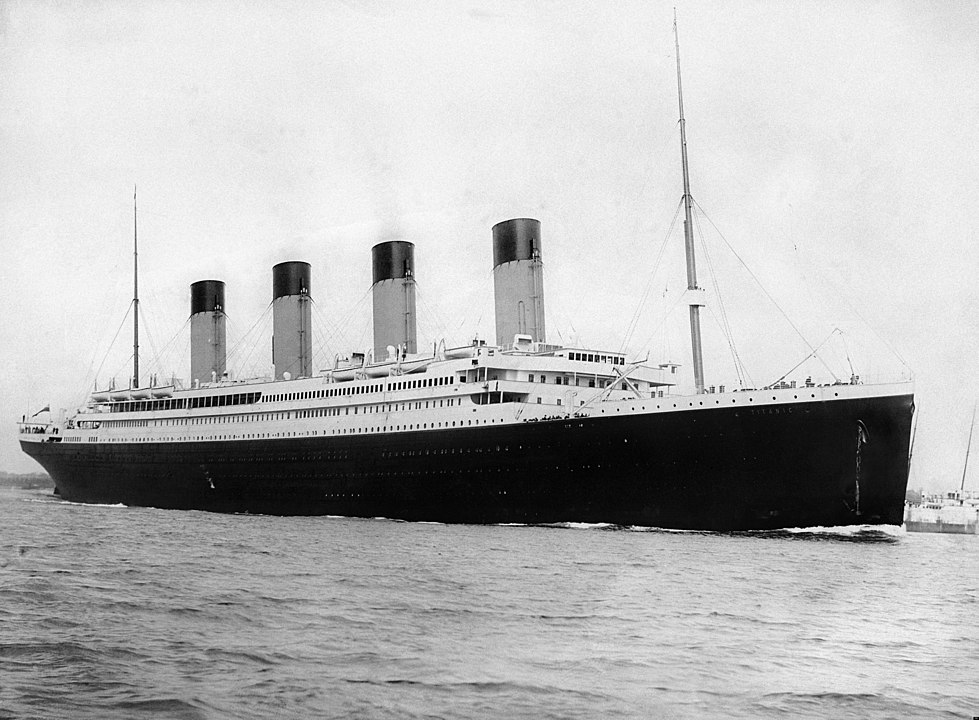